![](https://www.jpl.nasa.gov/images/kepler/20160718/pia20698-16.jpg)

# Overview

I'm pretty new to data science, Kaggle, numpy, pandas, seaborn/matplotlib, etc. This is my first Kaggle kernel/data science notebook I'm sharing. Currently a student at UNC Charlotte. Any and all feedback is appreciated.

We are looking at ~10,000 objects of interest found by [NASA's Kepler Space Telescope](https://www.nasa.gov/mission_pages/kepler/overview/index.html). Launched in 2009 and retired in 2018, Kepler's nine-year mission focused on finding [**exoplanets**](https://en.wikipedia.org/wiki/Exoplanet); planets scattered across the Milky Way orbiting stars far, far away from our Solar System, but in or near [habitable zones](https://en.wikipedia.org/wiki/Circumstellar_habitable_zone). A description of all the columns can be found [here](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html).

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # directory stuff
import matplotlib.pyplot as plt # plotting data
from mpl_toolkits.mplot3d import Axes3D # 3D MPL
import seaborn as sns # a library built on top of matplotlib, makes statistical plotting easier and prettier
from sklearn.cluster import KMeans # clustering
import math

#print(os.listdir("../input"))

# Choosing & Cleaning Data
## Loading in Data

In [2]:
raw_data = pd.read_csv('../input/cumulative.csv')

## Narrowing focus (dropping columns)

We're going to drop some columns that aren't super important for describing these objects of interest.

Evaluating the relevance/meaning of each column we have and deciding which ones would be significant for analysis. Using the column descriptions on the NASA Exoplanet Archive site [here](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html). 

Let's see what we have.

In [3]:
print('Here are all the columns:\n')
print(raw_data.columns.tolist())

Here are all the columns:

['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']


These column names are difficult to understand, I'll change them later.

Columns I'm going to drop:

* **koi_pdisposition**.
    * This column describes whether a KOI [Kepler Object of Interest] is considered a candidate for an exoplanet, or a false positive, or a confirmed exoplanet.) 
    * **koi_disposition** is the same, but also incorporates newer, peer-reviewed/published information from the Exoplanet Archive, so we'll keep that and get rid of **koi_pdisposition,** which is from the Kepler pipeline. What's a pipeline? I don't know, I'm not a JPL engineer. I just work here, dude.
* **koi_tce_plnt_num** and **koi_tce_delivname.** 
    * **koi_tce_plnt_num** is the TCE (Threhold-Crossing Event) Planet Number federated to the KOI.
    * **koi_tce_delivname** is TCE delivery name corresponding to the TCE data federated to the KOI.
* all the error columns (**koi_period_err1**, **koi_impact_err2**, etc...)
    * These columns contain uncertainty values for their corresponding columns, e.g. **koi_period_err1** and **koi_period_err2** are the positive and negative uncertanties for koi_period, respectively.
* **kepler_name.**
    * Kepler number name in the form "Kepler-N," plus a lower-case letter, identifying the planet.
    * Despite this being super cool, only the confirmed planets have these, everything else has a NaN value here. So when we try to drop rows with NaN values, everything besides the confirmed exoplanets will get dropped... which we don't want. We can always cross-reference from the cleaned-out dataset back to this one if we really want an object's Kepler name.

Okay, let's drop the data.

In [4]:
# aforementioned columns we don't want
koi_pond = ['koi_pdisposition', 'koi_tce_plnt_num', 'koi_tce_delivname', 'kepler_name']

# gonna iterate through the columns of the raw data to add the uncertainty/error ones to the drop-list (koi_pond)
cols = raw_data.columns

# to make dropping the error columns easier, I'm just going to go through the whole list and drop every column with 'err' in the name. 
for c in cols:
    if 'err' in c:
        koi_pond.append(c)

# finalize changes, but hold on to the raw data in case we need it later
data = raw_data.drop(koi_pond, axis = 1)

print("Dropped:\n\n", koi_pond)
print(f"\nYour dataset had {raw_data.shape[1]} columns.\nIt now has {data.shape[1]} columns.")

Dropped:

 ['koi_pdisposition', 'koi_tce_plnt_num', 'koi_tce_delivname', 'kepler_name', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol_err1', 'koi_insol_err2', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad_err1', 'koi_srad_err2']

Your dataset had 50 columns.
It now has 24 columns.


## Dropping Rows

We have to get rid of rows with NaN values.

In [5]:
data = data.dropna()
print(f"The dataset had {raw_data.shape[0]} rows. It now has {data.shape[0]} rows.\n({raw_data.shape[0]-data.shape[0]} rows were dropped, leaving you with {round(((data.shape[0]/raw_data.shape[0])*100),2)}% of the original number of entries.)")

The dataset had 9564 rows. It now has 7994 rows.
(1570 rows were dropped, leaving you with 83.58% of the original number of entries.)


## Renaming Columns

We need to rename these columns so they're intelligible during our exploratory analysis. There are 25 of them, and keeping up with 25 **koi_this** and **koi_that**s is would be a headache. 

In [6]:
data.rename(columns={'kepid':'kepler_id','kepoi_name':'koi_name','koi_disposition':'plnt_disposition', 'koi_score':'plnt_disp_confidence',
                     'koi_fpflag_nt':'flag_nTransitLk', 'koi_fpflag_ss':'flag_scndEvent', 'koi_fpflag_co':'flag_centroidOffset', 
                     'koi_fpflag_ec':'flag_ephMatch', 'koi_period':'orbital_period','koi_time0bk':'transit_epoch','koi_impact':'impact_parameter',
                     'koi_duration':'transit_duration','koi_depth':'transit_depth', 'koi_prad':'planetary_radius', 'koi_teq':'equ_temp',
                     'koi_insol':'insolation_flux','koi_model_snr':'transit_sigToNoise','koi_steff':'stellar_eff_temp','koi_slogg':'stellar_surf_gravity',
                     'koi_srad':'stellar_radius','ra':'right_acension','dec':'declination','koi_kepmag':'kepler_magnitude'
                    }, inplace = True)

data.tail()

,rowid,kepler_id,koi_name,plnt_disposition,plnt_disp_confidence,flag_nTransitLk,flag_scndEvent,flag_centroidOffset,flag_ephMatch,orbital_period,...,planetary_radius,equ_temp,insolation_flux,transit_sigToNoise,stellar_eff_temp,stellar_surf_gravity,stellar_radius,right_acension,declination,kepler_magnitude
9559,9560,10031643,K07984.01,FALSE POSITIVE,0.000,0,0,0,1,8.589871,...,1.11,929.0,176.40,8.4,5638.0,4.296,1.088,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,FALSE POSITIVE,0.000,0,1,1,0,0.527699,...,29.35,2088.0,4500.53,453.3,5638.0,4.529,0.903,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,CANDIDATE,0.497,0,0,0,0,1.739849,...,0.72,1608.0,1585.81,10.6,6119.0,4.444,1.031,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,FALSE POSITIVE,0.021,0,0,1,0,0.681402,...,1.07,2218.0,5713.41,12.3,6173.0,4.447,1.041,294.16489,47.176281,15.385
9563,9564,10156110,K07989.01,FALSE POSITIVE,0.000,0,0,1,1,4.856035,...,1.05,1266.0,607.42,8.2,6469.0,4.385,1.193,297.00977,47.121021,14.826


Making a dictionary explaining all the columns so I don't have to check the website every time:

In [7]:
columns_list = data.columns.tolist()
print(columns_list)

['rowid', 'kepler_id', 'koi_name', 'plnt_disposition', 'plnt_disp_confidence', 'flag_nTransitLk', 'flag_scndEvent', 'flag_centroidOffset', 'flag_ephMatch', 'orbital_period', 'transit_epoch', 'impact_parameter', 'transit_duration', 'transit_depth', 'planetary_radius', 'equ_temp', 'insolation_flux', 'transit_sigToNoise', 'stellar_eff_temp', 'stellar_surf_gravity', 'stellar_radius', 'right_acension', 'declination', 'kepler_magnitude']


In [8]:
desc_list = [
    'the row ID',
    'target identification number as listed in the Kepler Input Catalog',
    'number used to track a KOI (Kepler Object of Interest)',
    'exoplanet status of this KOI from the Exoplanet Archive. Values are either FALSE POSITIVE, CANDIDATE, or CONFIRMED [exoplanet]',
    'value between 0 and 1 indicating confidence in KOI disposition.  For CANDIDATEs, a higher value indicates more confidence in its disposition, while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition.',
    'not transit-like. flag indicating a KOI whose light curve is not consistent with that of a transiting planet. This includes, but is not limited to, instrumental artifacts, non-eclipsing variable stars, and spurious (very low SNR) detections.',
    'stellar eclipse. flag indicating a KOI that is observed to have a significant secondary event, transit shape, or out-of-eclipse variability, which indicates that the transit-like event is most likely caused by an eclipsing binary. ',
    'centroid offset. flag indicating a KOI where the source of the signal is from a nearby star, as inferred by measuring the centroid location of the image both in and out of transit, or by the strength of the transit signal in the target\'s outer (halo) pixels as compared to the transit signal from the pixels in the optimal (or core) aperture',
    'ephemeris match indicates contamination. flag indicating a KOI that shares the same period and epoch as another object and is judged to be the result of flux contamination in the aperture or electronic crosstalk.',
    'orbital period (days)',
    'The time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days. The offset corresponds to 12:00 on Jan 1, 2009 UTC.',
    'The sky-projected distance between the center of the stellar disc and the center of the planet disc at conjunction, normalized by the stellar radius.',
    'Transit Duration (hours). The duration of the observed transits. Duration is measured from first contact between the planet and star until last contact.',
    'Transit Depth (parts per million). The fraction of stellar flux lost at the minimum of the planetary transit.',
    'Planetary radius (Earth radii). The product of the planet-star radius ratio and the stellar radius.',
    'Equilibrium Temperature (Kelvin). An approximate temperature of the planet/object.',
    'Insolation Flux [Earth flux]. Insolation flux is another way to give the equilibrium temperature. It depends on the stellar parameters (specifically the stellar radius and temperature), and on the semi-major axis of the planet. It\'s given in units relative to those measured for the Earth from the Sun.',
    'Transit Signal-to-Noise. Transit depth normalized by the mean uncertainty in the flux during the transits.',
    'Stellar Effective Temperature (Kelvin). The photospheric temperature of the star the KOI orbits.',
    'Stellar Surface Gravity (log_10 (cm/s^2)). The base-10 logarithm of the acceleration due to gravity at the surface of the star.',
    'Stellar Radius (solar radii). The photospheric radius of the star.',
    'KIC Right Acension',
    'KIC Declination',
    'Kepler-band magnitude',
]

In [9]:
columns_desc = dict(zip(columns_list, desc_list))
columns_desc['flag_ephMatch']

'ephemeris match indicates contamination. flag indicating a KOI that shares the same period and epoch as another object and is judged to be the result of flux contamination in the aperture or electronic crosstalk.'

# Exploratory Analysis & Visualization: Overview

These are the areas I'm interested in looking at so far:

* the **stars** orbited by the objects Kepler found
* the **objects themselves**
* the relationships between the various flags and the disposition of objects, i.e. which flags are the best indicators for predicting whether an object is an exoplanet or not?

# Classifying Stars

Let's look at the properties of the **stars** these KOIs orbit.

Here's what we know about these stars:

* **Stellar Effective Temperature (K)** 
    * Variable: **stellar_eff_temp**
    * The photospheric temperature of the star.
* **Stellar Surface Gravity (log10(cm/seconds squared))** 
    * Variable: **stellar_surf_gravity**
    * The base-10 logarithm of the acceleration due to gravity at the surface of the star.
* **Radius (solar radii)** 
    * Variable: **stellar_radius**
    * The photospheric radius of the star


Let's figure out which **spectral class** each star is in, then store the result in our DataFrame. [You can read about spectral classification here.](https://astro.unl.edu/naap/hr/hr_background1.html) 

Basically, you can figure out what elements are in a star by looking at the light it puts out and graphing its **intensity** and **wavelength**. From this, you can determine the star's its **temperature** and **peak wavelength (color)**.
![](https://astro.unl.edu/naap/hr/graphics/absorption.png)

We don't have information about the spectra of these stars, but color would be good for visualization. We'll use the **temperature** of these stars to infer their **colors**.

![](https://qph.fs.quoracdn.net/main-qimg-45d870d0f3bbc3ce85aaac31aebf0b7e.webp)

### Spectral Classification

In [10]:
# function that returns a classification for a star

star_types = ['O','B','A','F','G','K','M']

def spectral_classify(temp):
    if temp > 33000:
        return star_types[0]
    elif temp > 10000:
        return star_types[1]
    elif temp > 7500:
        return star_types[2]
    elif temp > 6000:
        return star_types[3]
    elif temp > 5200:
        return star_types[4]
    elif temp > 3700:
        return star_types[5]
    else:
        return star_types[6]

In [11]:
spectral_classes = [] # will hold the results of spectral classification

for temp in data['stellar_eff_temp'].values: # classify all the stars in the dataset
    spectral_classes.append(spectral_classify(temp))

data['stellar_spectral_cl'] = spectral_classes
print('Spectral classes added to dataset.')

Spectral classes added to dataset.


# Visualizing & Grouping Stars


We'll use this color palette for Seaborn so we can see the colors of stars when we graph them.

* Blue **(O)**: <span style="color:#0877ff"> *#0877ff* </span>

* Blue-white **(B)**: <span style="color:#94b6ff"> *#94b6ff* </span>

* White **(A)**: *#ffffff*

* Yellow-white **(F)**: <span style="color:#fffb91"> *#fffb91* </span>

* Yellow **(G)**: <span style="color:#fcf403"> *#fcf403* </span>

* Orange **(K)**: <span style="color:#fc8403"> *#fc8403* </span>

* Red **(M)**: <span style="color:#fc0303"> *#fc0303* </span>

In [12]:
# OBAFGKM palette: red, orange, yellow, yellow-white, white, blue-white, blue
star_colors = ['#fc0303','#fc8403','#fcf403', '#fffb91', '#ffffff','#94b6ff','#0877ff']
star_palette = dict(O=star_colors[6], B=star_colors[5], A=star_colors[4], F=star_colors[3], 
                             G=star_colors[2],K=star_colors[1],M=star_colors[0])

### Spectral Class

Histograms showing what spectral classes our stars are in, grouped based on **plnt_disposition**, which indicates whether or not the KOIs orbiting them are exoplanets (or exoplanet candidates).

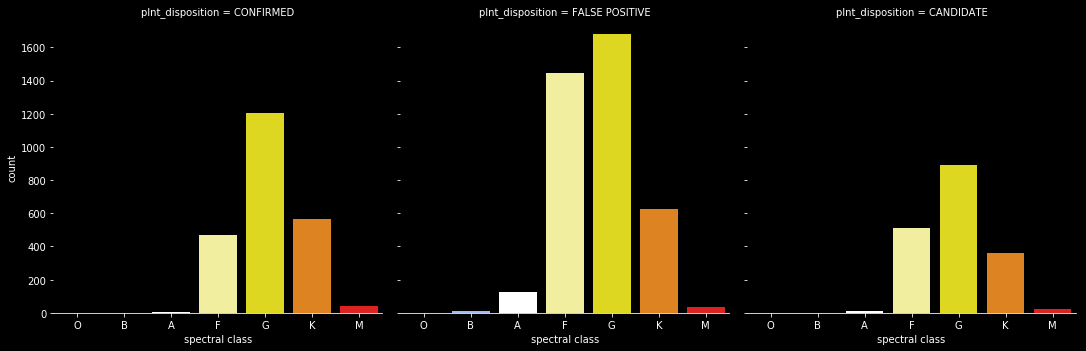

In [13]:
plt.style.use("dark_background")
ax = sns.catplot(x="stellar_spectral_cl",col='plnt_disposition', kind="count", order=['O','B','A','F','G','K','M'], palette=dict(O=star_colors[6], B=star_colors[5], A=star_colors[4], F=star_colors[3], G=star_colors[2],K=star_colors[1],M=star_colors[0]), data=data)
ax.set(xlabel='spectral class')
ax.despine(left=True, bottom=False)

plt.show()

#### Observations:

* Overall, these objects of interest orbit mostly **F-**, **G-**, and **K-type** stars, with a small amount orbiting **A-types** and even less orbiting **M-** and **B-type** stars.
* The confirmed & potential planets pretty almost exclusively orbit **F-, G-** and **K-types.**

### Surface Gravity vs. Radius

Here's **stellar surface gravity** *(stellar_surf_gravity)* vs. **stellar radius** *(stellar_radius)*, representing each star in its color.

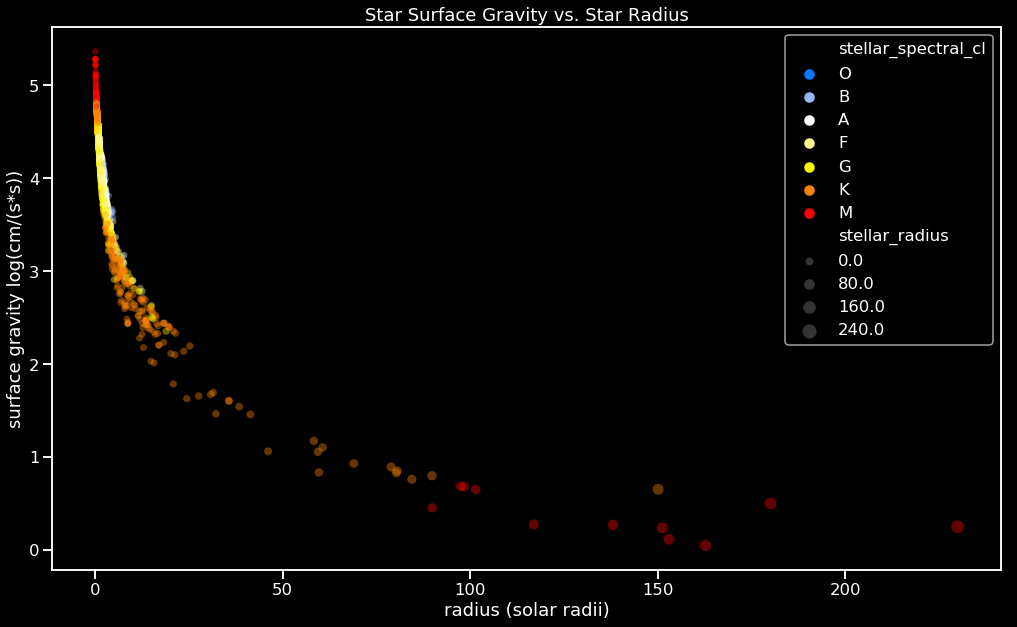

In [14]:
#sns.set_style("dark")
plt.style.use("dark_background")
sns.set_context('talk')
plt.figure(figsize=(17,10))
ax = sns.scatterplot(x='stellar_radius',y='stellar_surf_gravity', data=data, 
                hue='stellar_spectral_cl', hue_order=['O','B','A','F','G','K','M'],
                palette=star_palette, 
                markers = '.',
                alpha=0.4,
                linewidth=0,
                size = 'stellar_radius'
                    )

ax.set(xlabel='radius (solar radii)', ylabel='surface gravity log(cm/(s*s))')

plt.title('Star Surface Gravity vs. Star Radius')
plt.show()

#### Observations:

* Surface gravity seems to decrease with radius. This agrees with what [we know already...](https://en.wikipedia.org/wiki/Surface_gravity#Relationship_of_surface_gravity_to_mass_and_radius) surface gravity of a celestial body (planet OR star) decreases with radius, if mass is held constant. It's important to note, though, that mass is **not** a constant in our data. Even so, I think the relationship is probably still visible here, I just wouldn't use this data to prove it. It's unfortunate we don't know the masses of these stars, then we probably could.
* Most of these stars are less than 50 solar radii (less than 50 times larger than the Sun).
* The largest stars are the redder ones. These are likely [red supergiants](https://en.wikipedia.org/wiki/Red_supergiant_star). Note that while they are very large, they are not necessarily the most massive, just the most voluminous. That is to say, they take up a lot of space, but they are not very dense compared to other stars.

Let's see if we can use unsupervised learning to group these stars.

### **[K-Means Clustering](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)** 

K-Means clustering of the stars in our dataset by the three original categories we were given- **radius, surface gravity, and temperature.** We'll use [scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Let's look at the elbow plot first.

2 3 4 5 6 7 8 9 

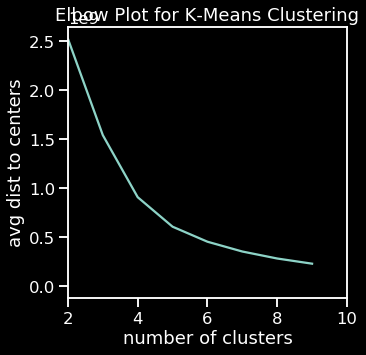

In [15]:
# try different values of k
max_n_clusters = 10 # max number of k to try
iterations = 5000 # how many times to try each k

category_list = ['stellar_radius','stellar_surf_gravity','stellar_eff_temp']

squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, max_iter = iterations).fit(data[category_list])
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    

plt.figure(figsize=(5,5))
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.title('Elbow Plot for K-Means Clustering')
plt.show()

4 seems to be the optimum number of clusters, so we'll use that.

In [16]:
numClusters = 4 # set number of clusters

# create and fit model
km_ = KMeans(n_clusters = numClusters, max_iter = iterations)
km_.fit(data[category_list])
km_.labels_ # cluster assignments

array([1, 1, 2, ..., 2, 2, 2], dtype=int32)

Adding cluster assignments to DataFrame:

In [17]:
data['star_cluster'] = km_.labels_

Quick overview of our clusters:

In [18]:
data.groupby('star_cluster')[category_list].mean()

,stellar_radius,stellar_surf_gravity,stellar_eff_temp
star_cluster,,,
0,2.600570,3.939290,8267.787565
1,1.439519,4.344606,5335.749839
2,1.307968,4.298712,6110.362004
3,5.087159,4.432630,4122.824561


Visualization of our clusters. (The colors represent clusters and NOT the real colors of the stars.)

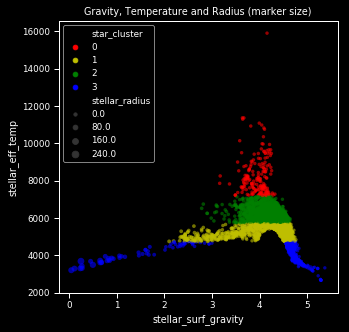

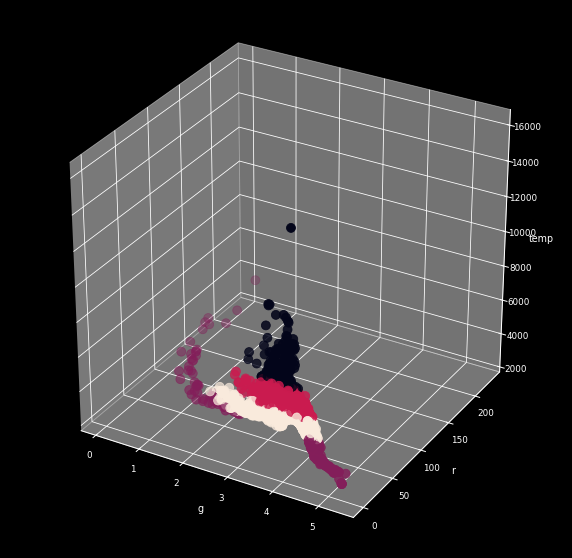

In [19]:
plt.figure(figsize=(5,5))
sns.set_context('paper')
data['star_cluster'] = data['star_cluster'].astype(str)

km_palette1 = ['r','y','g','b',]

if numClusters == len(km_palette1):
    ax = sns.scatterplot(x='stellar_surf_gravity',y='stellar_eff_temp',data=data,
                        linewidth=0, alpha=0.6,
                        size='stellar_radius',
                        hue='star_cluster', palette=km_palette1)
else:
    print("Palette is wrong length.")
    

plt.title('Gravity, Temperature and Radius (marker size)')
plt.show()

# SECOND GRAPH

# TODO: Convert cluster data to numeric

star_cluster_colors = []

for val in data['star_cluster']:
    if float(val) != 0:
        star_cluster_colors.append(1/float(val))
    else:
        star_cluster_colors.append(0)

    
km3d = plt.figure(figsize=(10,10)).gca(projection='3d')
km3d.scatter(data['stellar_surf_gravity'], data['stellar_radius'], data['stellar_eff_temp'], c=star_cluster_colors, s=80, cmap='rocket')
km3d.set_xlabel('g')
km3d.set_ylabel('r')
km3d.set_zlabel('temp')
plt.show()

## Looking for Correlations
Let's look at a correlation matrix for our dataset:

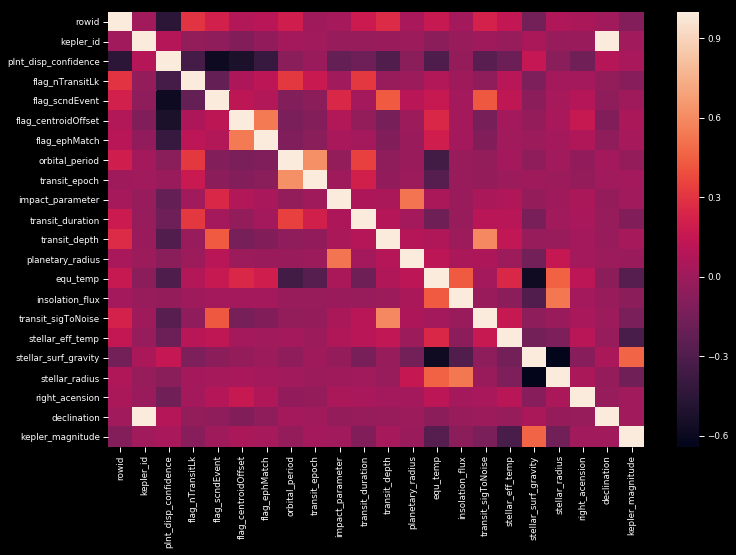

In [20]:
# calculate the correlation matrix
corr = data.corr()

plt.figure(figsize = (12,8))
# plot the heatmap
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=False)
plt.show()

#### Observations:

* flag_scndEvent negative with plnt_disp_confidence
* as shown before, strong negative correlation betwen stellar surface gravity and stellar radius
* negative correlation between stellar surface gravity and planet's equilibrium temperature
* transit_sigToNoise with transit_depth
